In [1]:
%matplotlib inline
import numpy
import pandas
import matplotlib.pyplot as plt

import os, sys
sys.path.append('../code')

# Generate events

In [48]:
from utils import straight_tracks_generator
events = straight_tracks_generator(n_events=1000, n_tracks=3, n_noise=10, sigma=0.5)

# Tracks Recognition

In [49]:
event = events[events.EventID == 0]
X = event.X.values.reshape(-1,1)
y = event.y.values

In [50]:
from TemplateMatching import SimpleTemplateMatching

stm = SimpleTemplateMatching(8, 1.0)
stm.fit(X, y)

params = stm.tracks_params_
labels = stm.labels_

# Plot True and Recognized Tracks

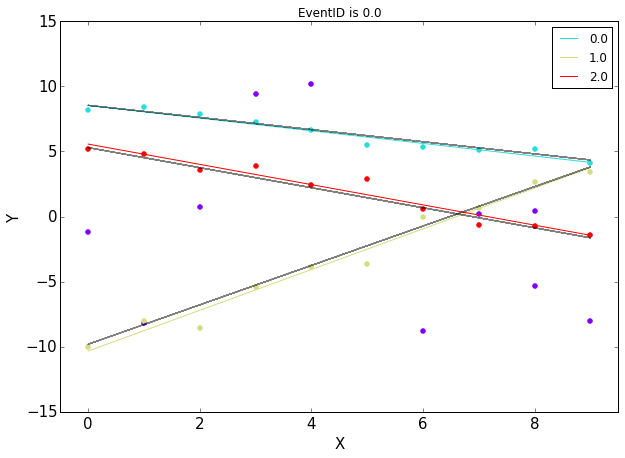

In [51]:
from utils import plot_straight_tracks
plot_straight_tracks(event, labels)
plt.xlim(-0.5, 9.5)
plt.ylabel('Y', size=15)
plt.xlabel('X', size=15)
plt.xticks(size=15)
plt.yticks(size=15)
plt.show()

# Tracks Reconstruction Quality

## Hits Matching

In [52]:
from metrics import HitsMatchingEfficiency

hme = HitsMatchingEfficiency()
hme.fit(event, labels)

print hme.efficiencies_
print hme.avg_efficiency_
print hme.recognition_efficiency_
print hme.ghost_rate_
print hme.clone_rate_

[ 1.          0.72727273  1.        ]
0.909090909091
1.0
0.0
0.0


## Parameters Matching

In [53]:
from metrics import ParameterMatchingEfficiency

pme = ParameterMatchingEfficiency(delta_k = .2, delta_b=1.)
pme.fit(event, labels)

print pme.recognition_efficiency_
print pme.ghost_rate_
print pme.clone_rate_

1.0
0.0
0.0


## All Metrics for All events

In [20]:
results = pandas.DataFrame(columns=['EventID', 'HmAvgEff',
                                    'HmRecoEff', 'HmGhostRate', 'HmCloneRate', 
                                    'PmRecoEff', 'PmGhostRate', 'PmCloneRate'])

for event_id in numpy.unique(events.EventID.values):
    
    event = events[events.EventID == event_id]
    X = event.X.values.reshape(-1,1)
    y = event.y.values
    
    stm = SimpleTemplateMatching(8, 1.)
    stm.fit(X, y)
    labels = stm.labels_
    
    hme = HitsMatchingEfficiency()
    hme.fit(event, labels)
    
    pme = ParameterMatchingEfficiency(delta_k = 0.4, delta_b=2.)
    pme.fit(event, labels)
    
    results.loc[len(results)] = [event_id, hme.avg_efficiency_, 
                                 hme.recognition_efficiency_, hme.ghost_rate_, hme.clone_rate_, 
                                 pme.recognition_efficiency_, pme.ghost_rate_, pme.clone_rate_]

In [21]:
results.head()

,EventID,HmAvgEff,HmRecoEff,HmGhostRate,HmCloneRate,PmRecoEff,PmGhostRate,PmCloneRate
0,0,0.733333,1.000000,0.000000,0,0.666667,0.333333,0
1,1,0.666667,0.666667,0.333333,0,0.666667,0.333333,0
2,2,0.939394,1.000000,0.000000,0,1.000000,0.000000,0
3,3,0.958333,1.000000,0.000000,0,1.000000,0.000000,0
4,4,0.576389,0.333333,0.333333,0,0.666667,0.000000,0


In [22]:
results[['HmRecoEff', 'HmGhostRate', 'HmCloneRate', 'PmRecoEff', 'PmGhostRate', 'PmCloneRate']].values.mean(axis=0)

array([ 0.913     ,  0.03766667,  0.01766667,  0.911     ,  0.04166667,
        0.01566667])

# Experiments

In [20]:
def get_metrics(n_events, n_tracks):
    
    events = straight_tracks_generator(n_events=n_events, n_tracks=n_tracks, n_noise=20, sigma=0.5)
    
    results = pandas.DataFrame(columns=['EventID', 'HmAvgEff',
                                        'HmRecoEff', 'HmGhostRate', 'HmCloneRate', 
                                        'PmRecoEff', 'PmGhostRate', 'PmCloneRate'])

    for event_id in numpy.unique(events.EventID.values):

        event = events[events.EventID == event_id]
        X = event.X.values.reshape(-1,1)
        y = event.y.values

        stm = SimpleTemplateMatching(8, 1.)
        stm.fit(X, y)
        labels = stm.labels_

        hme = HitsMatchingEfficiency()
        hme.fit(event, labels)

        pme = ParameterMatchingEfficiency(delta_k = 0.2, delta_b=1.0)
        pme.fit(event, labels)

        results.loc[len(results)] = [event_id, hme.avg_efficiency_, 
                                     hme.recognition_efficiency_, hme.ghost_rate_, hme.clone_rate_, 
                                     pme.recognition_efficiency_, pme.ghost_rate_, pme.clone_rate_]
        
    metrics = results[['HmRecoEff', 'HmGhostRate', 'HmCloneRate', 
                       'PmRecoEff', 'PmGhostRate', 'PmCloneRate']].values.mean(axis=0)
    
    return metrics

def get_metrics_dependencies(n_events, n_tracks):
    
    results = pandas.DataFrame(columns=['HmRecoEff', 'HmGhostRate', 'HmCloneRate', 
                                        'PmRecoEff', 'PmGhostRate', 'PmCloneRate'])
    
    for i in n_tracks:
        
        results.loc[len(results)] = get_metrics(n_events, i)
        
    return results

In [28]:
n_tracks = [1, 2, 3, 4, 5, 7, 10, 12, 15, 20, 25, 30, 40, 50, 60, 70, 80, 90, 100]
results2 = get_metrics_dependencies(1000, n_tracks)
results2.head()

,HmRecoEff,HmGhostRate,HmCloneRate,PmRecoEff,PmGhostRate,PmCloneRate
0,0.99500,0.02100,0.018000,0.909000,0.138000,0.0000
1,0.96100,0.06400,0.026500,0.857000,0.193000,0.0055
2,0.89700,0.11600,0.029667,0.795667,0.240333,0.0080
3,0.84425,0.17275,0.023250,0.747250,0.287750,0.0075
4,0.76560,0.24600,0.024000,0.648200,0.375000,0.0126


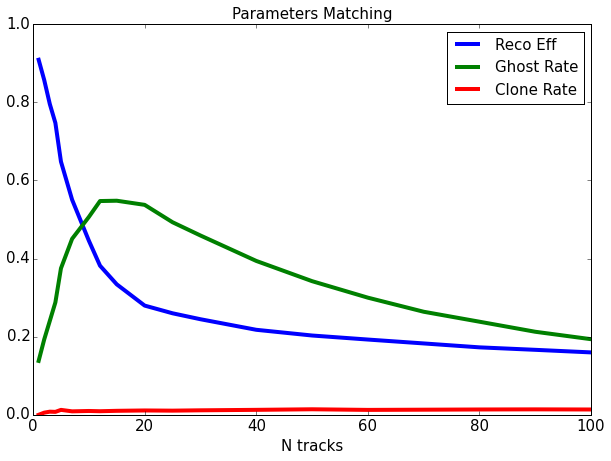

In [31]:
plt.figure(figsize=(10, 7))
plt.plot(n_tracks, results2['PmRecoEff'].values, linewidth=4, label='Reco Eff')
plt.plot(n_tracks, results2['PmGhostRate'].values, linewidth=4, label='Ghost Rate')
plt.plot(n_tracks, results2['PmCloneRate'].values, linewidth=4, label='Clone Rate')
plt.legend(loc='best', prop={'size':15})
plt.xlabel('N tracks', size=15)
plt.xticks(size=15)
plt.yticks(size=15)
plt.title('Parameters Matching', size=15)
plt.show()

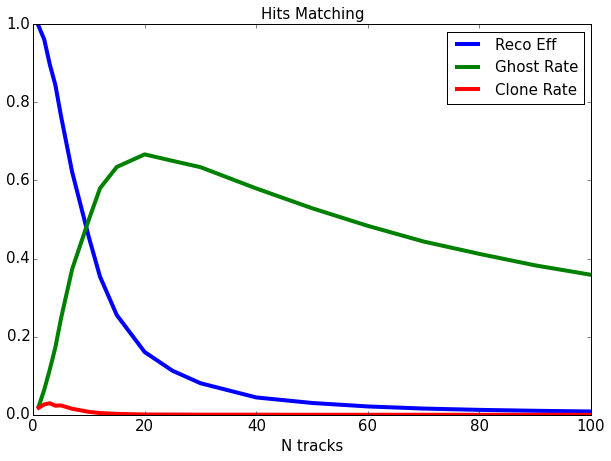

In [42]:
plt.figure(figsize=(10, 7))
plt.plot(n_tracks, results2['HmRecoEff'].values, linewidth=4, label='Reco Eff')
plt.plot(n_tracks, results2['HmGhostRate'].values, linewidth=4, label='Ghost Rate')
plt.plot(n_tracks, results2['HmCloneRate'].values, linewidth=4, label='Clone Rate')
plt.legend(loc='best', prop={'size':15})
plt.xlabel('N tracks', size=15)
plt.xticks(size=15)
plt.yticks(size=15)
plt.title('Hits Matching', size=15)
plt.show()